<a href="https://colab.research.google.com/github/sachinkavindaa/ML-Project/blob/master/New_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone 'https://github.com/sachinkavindaa/Machine-learning-with-Python'

Cloning into 'Machine-learning-with-Python'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 137 (delta 44), reused 129 (delta 36), pack-reused 0
Receiving objects: 100% (137/137), 1.01 MiB | 8.21 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [10]:
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp, tanh
import matplotlib.pyplot as plt
import numpy as np

# Initialize a network


def initialize_network(n_inputs, n_hidden, n_outputs):
    """
        Note: No layer is created for the input layer
    """
    network = list()
    # Create dictionary to store WEIGHTS as: [{'weights': [x x x] }, {...}, {'weights': [x x x]}]
    hidden_layer = [{'weights': [random() for i in range(n_inputs + 1)]}
                    for i in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights': [random() for i in range(n_hidden + 1)]}
                    for i in range(n_outputs)]
    network.append(output_layer)
    # print("")
    ####print("LAYERS i",n_inputs,"h",n_hidden,"o",n_outputs)
    # for layer in network:
    # print(layer)
    # print("")
    return network


# Initialize a network according to an array
# input:	(tab){length(tab) = nb layers / tab values = nb neuron}
# return:	(network)An array of dictionnary, 1 dic for 1 layer = [{'weights': [x x x] }, {...}, {'weights': [x x x]}]
#		1 network = [layer1, layer2, ...] (no layer for input !!!!)
#		1 layer = [neuron1, neuron2, ...]
#		1 neuron = [{'weights': [x1 x2 x3 ...] } where x1 is the weight of the first synapse linked to this neuron
#               The length of weight is the number of input + 1
def initialize_network_custom(tab):
    network = list()
    for idx_layer in range(1, len(tab)):
        layer = []
        # For each neuron
        for idx_neuron in range(tab[idx_layer]):
            randomWeight = []
            # Create x weights + 1 (bias) for each neuron
            for k in range(tab[idx_layer-1]+1):
                randomWeight.append(random())
            # Create dictionnary
            temp = {'weights': randomWeight}
            layer.append(temp)
        network.append(layer)
    # print("")
    # for layer in network:
    #    print("layer:",layer)
    #    print("")
    return network


# Calculate neuron activation for an input: activation = sum(weight_i * input_i) + bias
# input:	(weights)weight array on 1 neuron
# input:	(inputs)neuron inputs (indexes are alligned with weight array)
# retrun:	(activation)current neuron value after applying activation (without transfer fct)
def activate(weights, inputs):
    # Add the bias weight (last index)
    activation = weights[-1]
    # Add other inputs*weights linked to our neuron
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

# Transfer neuron activation: sigmoid function or sigmoid' according to derivate arg


def transfer_sigmoid(x, derivate):
    if derivate == 0:
        # x = activation
        return 1.0 / (1.0 + exp(-x))
    else:
        # x = neuron outputs, calculate the derivative of an neuron output
        return x * (1.0 - x)

# Transfer neuron activation: tanh function or tanh' according to derivate arg


def transfer_tanh(x, derivate):
    if derivate == 0:
        return tanh(x)
    else:
        return 1.0 - tanh(x)**2

# Forward propagate input to a network output
# input:	(network)Our neural network
# input:	(row)1 train pattern
# return	the outputs of the last layer.


def forward_propagate(network, row, transfer):
    # first input is set by the dataset array
    inputs = row
    for layer in network:
        # Array of neuron value after applying activate+Transfer (for 1 layer)
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            # Add the neuron output into the neuron item (before 'weight')
            neuron['output'] = transfer(activation, 0)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    # returns the outputs from the last layer
    return inputs

# Backpropagate error and store it into delta of neurons


def backward_propagate_error(network, expected, transfer):
    # Start from last layer
    for idx_layer in reversed(range(len(network))):
        layer = network[idx_layer]
        errors = list()
        # --- (2) Error computed for the hidden layers: error = (weight_k * error_j) * transfer_derivative(output)
        if idx_layer != len(network)-1:
            for idx_neuron_layer_N in range(len(layer)):
                error = 0.0
                # --- (A) error = Sum(delta * weight linked to this delta)
                #                for each neuron[LAYER N+1] linked to this neuron[LAYER N] (current layer)
                for neuron_layer_M in network[idx_layer + 1]:
                    error += (neuron_layer_M['weights']
                              [idx_neuron_layer_N] * neuron_layer_M['delta'])
                errors.append(error)
        # --- (1) Error computed for the last layer: error = (expected - output) * transfer_derivative(output)
        else:
            # --- (A) Store the difference between expected and output for each output neuron in errors[]
            for idx_neuron in range(len(layer)):
                neuron = layer[idx_neuron]
                errors.append(expected[idx_neuron] - neuron['output'])
        # --- (B) Store the error signal in delta for each neuron
        for idx_neuron in range(len(layer)):
            neuron = layer[idx_neuron]
            neuron['delta'] = errors[idx_neuron] * \
                transfer(neuron['output'], 1)

# Update network weights with error: weight += (learning_rate * error * input)
# Note: forward and backward propagations must be already done.
# input		(network)Our neural network
# input		(row)1 train pattern
# input:	(l_rate)learning rate controls how much to change the weight to correct for the error.
#			For example, a value of 0.1 will update the weight 10% of the amount that it possibly could be updated.


def update_weights(network, row, l_rate):
    for idx_layer in range(len(network)):
        inputs = row[:-1]
        if idx_layer != 0:
            # --- (1) Store the outputs of the layer N-1 into inputs[]
            inputs = [neuron['output'] for neuron in network[idx_layer - 1]]
        for neuron in network[idx_layer]:
            # --- (2) Compute the new weights for each neuron of the layer N
            for idx_input in range(len(inputs)):
                neuron['weights'][idx_input] += l_rate * \
                    neuron['delta'] * inputs[idx_input]
            # --- (3) Update the bias of the neuron (input=1 below)
            neuron['weights'][-1] += l_rate * neuron['delta'] * 1

# expected = one-hot encoding, one class for one output (one output = unic binary value)
# if 2 classes (2 integer out values), expected = [0, 1] and = [1, 0]
# write '1' at the index given by the integer output (if output = 2, set at the index 2: [0,0,1] )


def one_hot_encoding(n_outputs, row_in_dataset):
    expected = [0 for i in range(n_outputs)]
    expected[row_in_dataset[-1]] = 1
    return expected

# Train a network for a fixed number of epochs, it is updated using stochastic gradient descent.
# input:	(network)Our neural network
# input:	(train)Dataset to train the neural network
# input:	(l_rate)learning rate controls how much to change the weight to correct for the error.
#			For example, a value of 0.1 will update the weight 10% of the amount that it possibly could be updated.
# input:	(n_epoch)Within each epoch, update the network for each row in the training dataset
# input:	(n_outputs)


def train_network(network, train, test, l_rate, n_epoch, n_outputs, transfer):
    accuracy = []
    for epoch in range(n_epoch):
        sum_error = 0
        # Apply for each row of the dataset the backprop
        for row in train:
            outputs = forward_propagate(network, row, transfer)
            expected = one_hot_encoding(n_outputs, row)
            sum_error += sum([(expected[i]-outputs[i]) **
                             2 for i in range(len(expected))])
            backward_propagate_error(network, expected, transfer)
            update_weights(network, row, l_rate)
        accuracy.append(get_prediction_accuracy(network, test, transfer))
    accuracies.append(accuracy)

# Make a prediction with a network


def predict(network, row, transfer):
    outputs = forward_propagate(network, row, transfer)
    # return the index with max value for each output (ex: output[i]=[0.1, 0.9, 0.2], prediciont[i] = 1)
    return outputs.index(max(outputs))


def get_prediction_accuracy(network, train, transfer):
    predictions = list()
    for row in train:
        prediction = predict(network, row, transfer)
        predictions.append(prediction)
    expected_out = [row[-1] for row in train]
    accuracy = accuracy_metric(expected_out, predictions)
    return accuracy

# Backpropagation Algorithm With Stochastic Gradient Descent


def back_propagation(train, test, l_rate, n_epoch, n_hidden, transfer):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    #network = initialize_network(n_inputs, n_hidden, n_outputs)
    network = initialize_network_custom([n_inputs, 5, n_outputs])
    layerPrint = []
    for i in range(len(network)):
        layerPrint.append(len(network[i]))
    print('network created: %d layer(s):' % len(network), layerPrint)
    train_network(network, train, test, l_rate, n_epoch, n_outputs, transfer)
    predictions = list()
    print("perform predictions on %d set of inputs:" % len(test))
    for row in test:
        prediction = predict(network, row, transfer)
        predictions.append(prediction)
    print("pred =", predictions)
    return(predictions)

# Load a CSV file


def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        csv_reader.__next__()
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

# Convert string column to float


def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

# Convert string column to integer


def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

# Find the min and max values for each column


def dataset_minmax(dataset):
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)]
    return stats

# Rescale dataset columns to the range 0-1


def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# Split a dataset into k folds


def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage


def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
# input		(dataset)train patterns
# input		(algorithm)function to init and train the network + perform predictions
# input		(n_folds)dataset spliter number
# input		(*args) = (l_rate, n_epoch, n_hidden)


def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    # k-fold cross-validation
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        # --- (1) Prepare inputs to train the network
        train_set = list(folds)        # Set all dataset
        # Remove the fold used to test the network
        train_set.remove(fold)
        train_set = sum(train_set, [])
        # --- (2) Prepare inputs to test the network (to make predictions)
        test_set = list()
        # Store each row of fold (test) in test_set[]
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        # --- (3) create network + train it + return its predictions
        predicted = algorithm(train_set, fold, *args)
        # --- (4) compare each prediction with the corresponding expected output in dataset
        actual = [row[-1] for row in fold]
        print(actual)
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
        print('- Training[%d] performed' % len(scores))
        print('---------------------------------------')
    return scores


seed(1)

accuracies = list()

filename = '/content/Machine-learning-with-Python/ML/Diabetes/diabetes.csv'

dataset = load_csv(filename)
# convert string numbers to floats
for i in range(len(dataset[0])-1):
    str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# normalize input variables to the range of 0 and 1 (range of the transfer function)
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
# evaluate algorithm:
# 5-fold cross validation is used.
# That means that 5 models are fit and evaluated on 5 different hold out sets. Each model is trained for 500 epochs.
n_folds = 5
l_rate = 0.1
n_epoch = 200
n_hidden = 8
print('---------------------------------------')
scores = evaluate_algorithm(dataset, back_propagation,
                            n_folds, l_rate, n_epoch, n_hidden, transfer_sigmoid)
print('Scores (per fold): %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))
subplot = ((n_folds / 2) + (n_folds % 2))*100 + 21

---------------------------------------
network created: 2 layer(s): [5, 2]
perform predictions on 153 set of inputs:
pred = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 

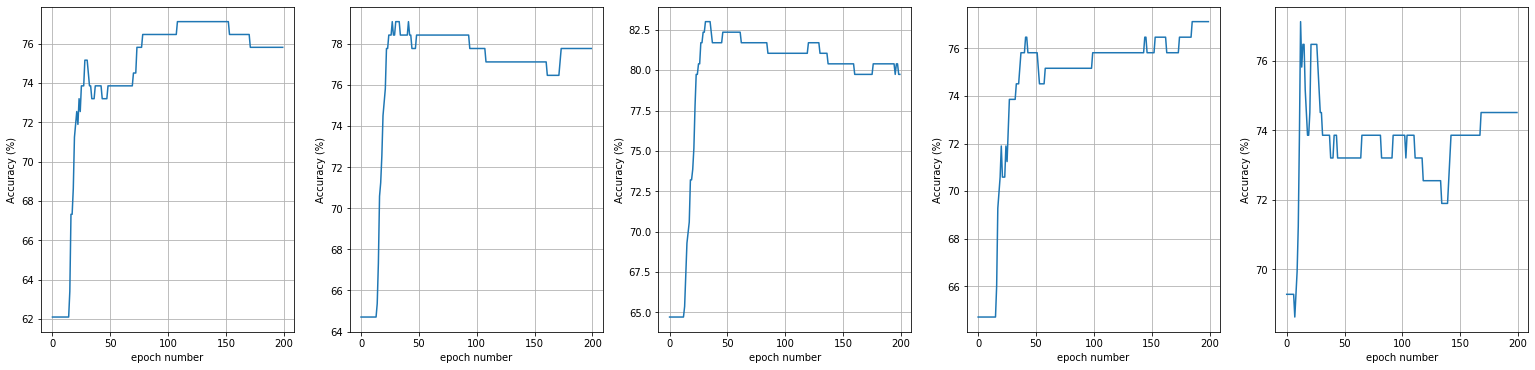

In [16]:
plt.figure(figsize=(30, 15))
for i in range(len(accuracies)):
    plt.subplot(subplot+i)
    plt.plot(accuracies[i])
    plt.grid(True)
    plt.ylabel('Accuracy (%)')
    plt.xlabel('epoch number')
plt.tight_layout()
plt.show()